# Laboratório 8
Material desenvolvido por Henrique Margotte e Aurora Pozo para a disciplina de Aprendizado de Máquina, para o curso de Informática Biomédica da UFPR, semestre 2025/2. Códigos baseados em exemplos da biblioteca scikit-learn e nos notebooks Python do livro "Inteligência Artificial: Uma Abordagem de Aprendizado de Máquina", 2ª edição.

# Exemplo 1: Agrupamento

Hoje veremos um pouco sobre aprendizado não supervisionado, por meio de algoritmos de Agrupamento, ou *Clustering*. Esse tipo de algoritmo se baseia na criação de grupos de dados, de forma que dados similares estejam em um mesmo grupo, ou *cluster*, e dados diferentes estejam em grupos distantes. Há diversas formas de se fazer isso, e veremos algumas a seguir.

Mas, o ponto principal desse algoritmo é que não sabemos os grupos, apenas deixamos o modelo separá-los a partir de alguma métrica estipulada, diferente de um algoritmo de classificação que possui uma taxa de acerto.

## Exemplo 1.1: Visualizando a Base
Antes de vermos os algoritmos, vamos preparar e explorar a base de dados `digits` para podermos utilizá-la em cluster. Por exemplo, podemos tentar agrupar as imagens que contém os mesmos números, mas sem saber qual número é qual! Para visualizar em um gráfico de duas dimensões, podemos utilizar tanto o PCA quanto o t-SNE.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

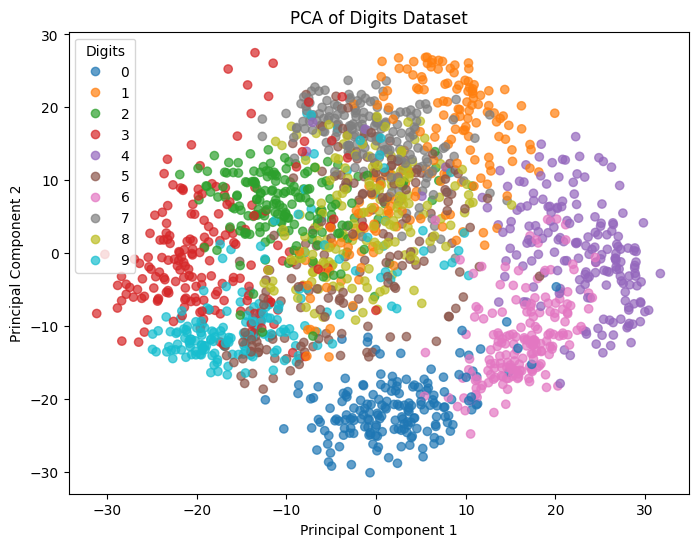

In [6]:
# Visualizando com PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(digits.data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=digits.target, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("PCA of Digits Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

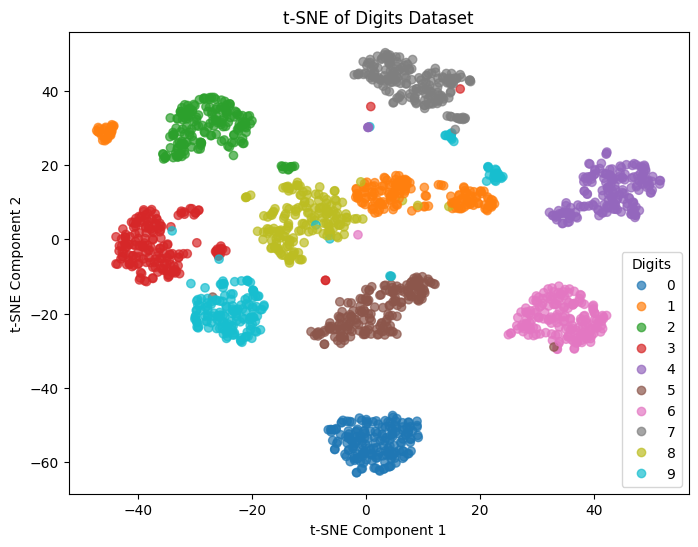

In [7]:
# Visualizando com TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=digits.target, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Podemos observar que o t-SNE nesse caso consegue separar os dados em grupos mais definidos, mas o PCA também apresenta regiões de uma mesma classe. Nossa ideia é que os clusters consigam identificar essas regiões por si só e como pertencentes à mesma classe!

## Exemplo 1.2: Baseados em Erro Quadrático: k-Médias
O algoritmo de k-Médias, ou *k-Means*, se baseia na seleção de `k` centroides, que servirão como centro de cada cluster, atribuindo os elementos mais próximos a esse centroide como pertencente ao respectivo cluster. Então, é calculado o erro quadrático entre todos os elementos do cluster e o centroide, alterando-se os centroides a cada interação para minimizar esse erro.

Veremos um exemplo utilizando o `KMeans` do scikit-learn e visualizando com o t-SNE.

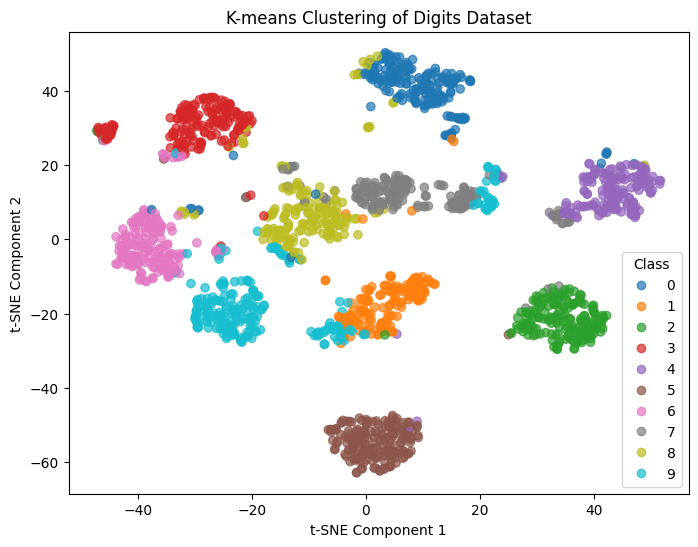

In [9]:
# K-médias
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(digits.data)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("K-means Clustering of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Podemos também visualizar quais são os centroides definidos pelo k-Médias, e as imagens mais próximas a eles.

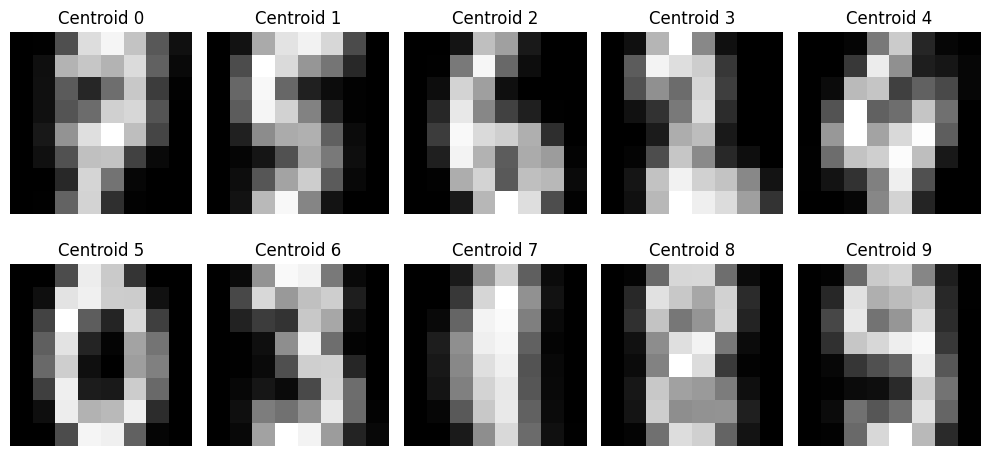

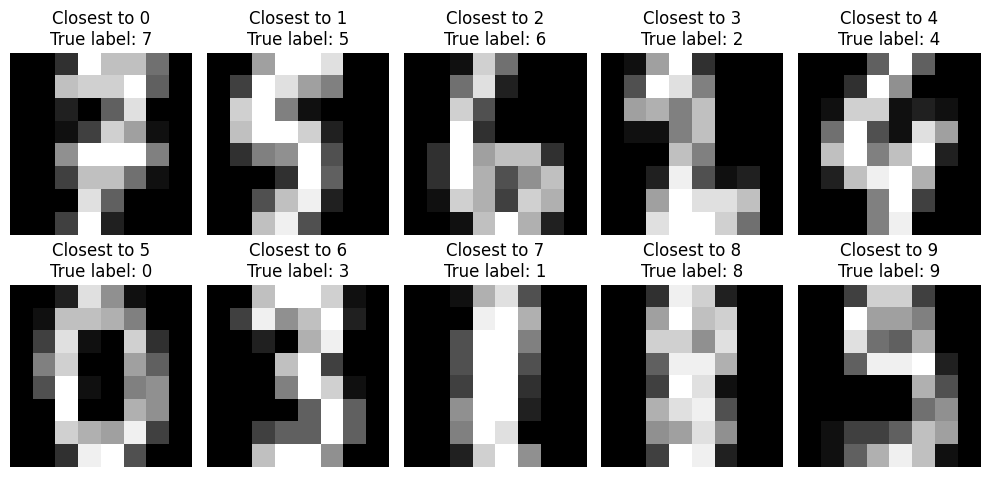

In [10]:
# Visualizando os centroides
centroids = kmeans.cluster_centers_
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(centroids[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Centroid {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualizando as imagens mais próximas dos centroides with true labels
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(centroids, digits.data)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(digits.images[closest[i]], cmap='gray')
    ax.set_title(f'Closest to {i}\nTrue label: {digits.target[closest[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Como temos as classes definidas, podemos tentar verificar quanto nosso cluster separou adequadamente. Para isso, vamos definir a classe de cada cluster como a classe da imagem mais próxima a cada centroide, então, medir o erro de classificação.

In [11]:
# Classificação baseada nos clusters
predicted_labels = np.zeros_like(labels)
for i in range(10):
    mask = (labels == i)
    if np.any(mask):
        closest_index = closest[i]
        predicted_labels[mask] = digits.target[closest_index]
accuracy = np.mean(predicted_labels == digits.target)
print(f'Acurácia de classificação baseada em clusters: {accuracy * 100:.2f}%')

Acurácia de classificação baseada em clusters: 86.14%


Isso seria uma tentativa de resolver um problema de classificação com clusters, que não se caracteriza como seu principal uso não supervisionado, mas nos dá uma ideia de como o modelo funciona. Veremos outros exemplo na mesma base.

## Exemplo 1.3: Baseados em Densidade: DBSCAN

O DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) é um algoritmo baseado em densidade. Ele identifica as regiões de maior densidade de dados e as define como clusters, encontrando pontos de menor densidade e os classificando como ruído. Diferente do k-Médias, o algoritmo define a quantidade de clusters, utilizando como base a distância entre os centros de densidade.

Veremos um exemplo utilizando o `DBSCAN` do scikit-learn. O hiperparâmetro `eps` define a distância máxima entre dois elementos para serem considerados vizinhos, já o `min_samples` define o número mínimo de vizinhos para formar uma região densa, elementos fora desse intervalo são considerados ruídos (Classe -1). O ajuste desses hiperparâmetros pode influenciar bastante o modelo, ainda mais em altas dimensões. Como exemplo, utilizaremos o DBSCAN aplicado na transformação 2D do t-SNE.

Número de clusters encontrados pelo DBSCAN: 9


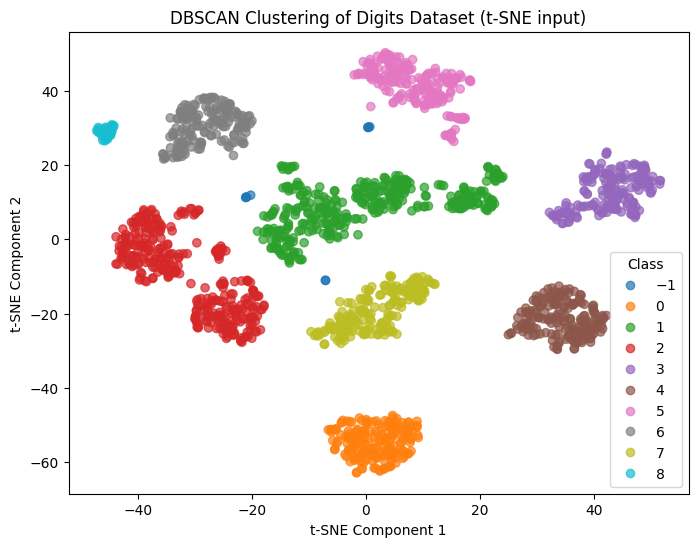

In [48]:
# DBSCAN on t-SNE embedding
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=5)
dbscan.fit(data_tsne)  # use the 2D t-SNE representation instead of the raw pixels
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f'Número de clusters encontrados pelo DBSCAN: {n_clusters}')
db_labels = dbscan.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=db_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("DBSCAN Clustering of Digits Dataset (t-SNE input)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

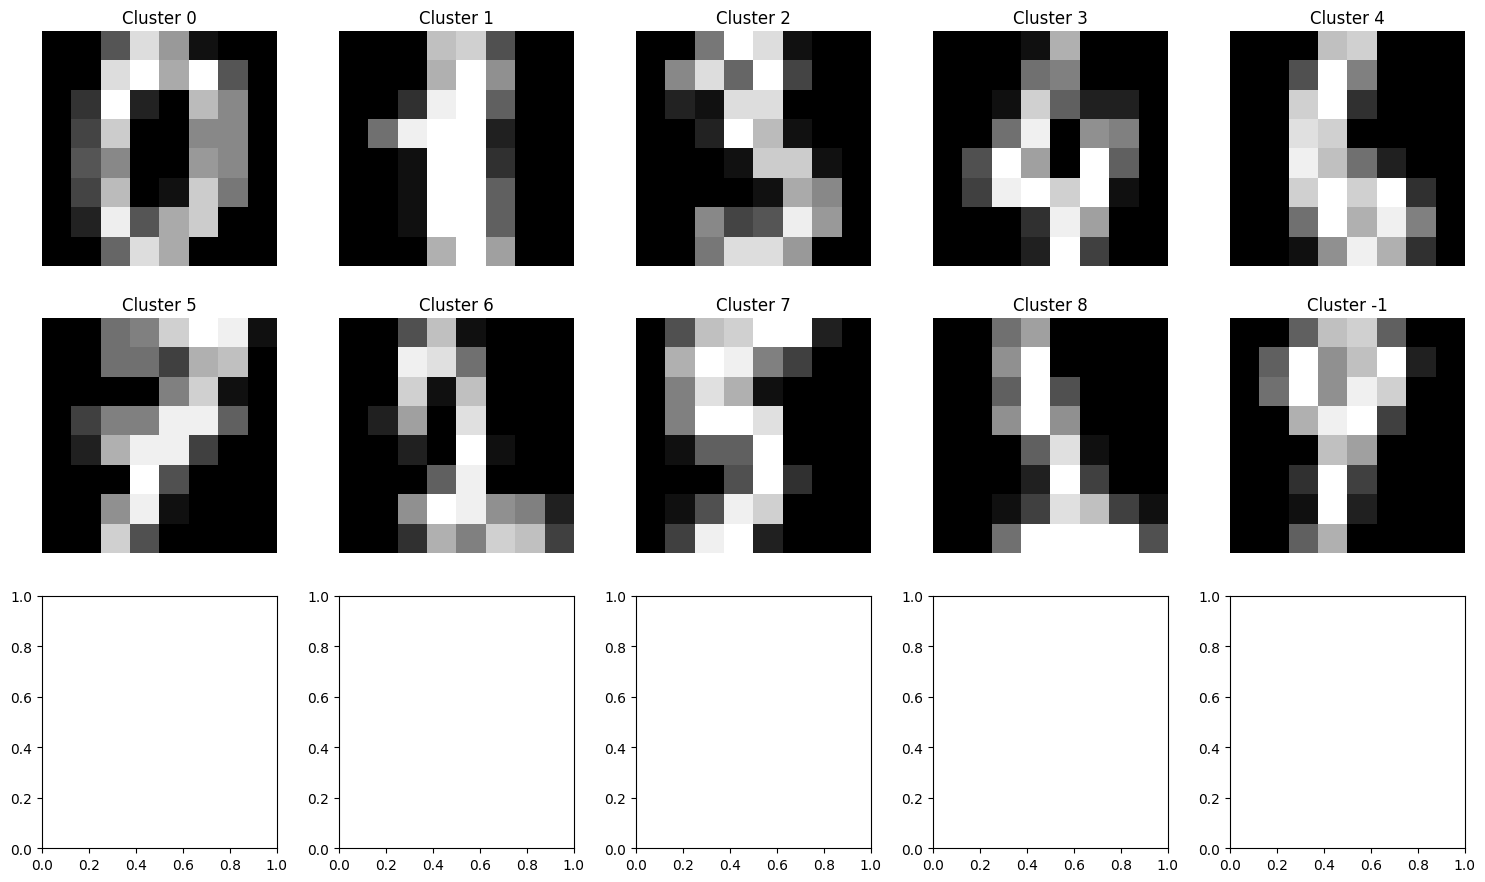

In [50]:
# Visualizando alguns elementos de cada cluster DBSCAN
unique_labels = set(db_labels)
fig, axes = plt.subplots(len(unique_labels) // 5 + 1, 5, figsize=(15, 3 * (len(unique_labels) // 5 + 1)))
for i, label in enumerate(unique_labels):
    cluster_indices = np.where(db_labels == label)[0]
    if len(cluster_indices) > 0:
        sample_index = cluster_indices[0]
        ax = axes.flatten()[i]
        ax.imshow(digits.images[sample_index], cmap='gray')
        ax.set_title(f'Cluster {label}')
        ax.axis('off')
plt.tight_layout()
plt.show()


## Exemplo 1.4: Baseados em Grafo: Cluster Espectral

Outro exemplo de tipo de cluster são os baseados em grafos. Eles definem cada elemento como um nó do grafo, os conectando com arestas. Então, as arestas são removidas com base em critérios estipulados, até se formar núcleos representando os clusters.

Veremos um exemplo com `SpectralClustering`.

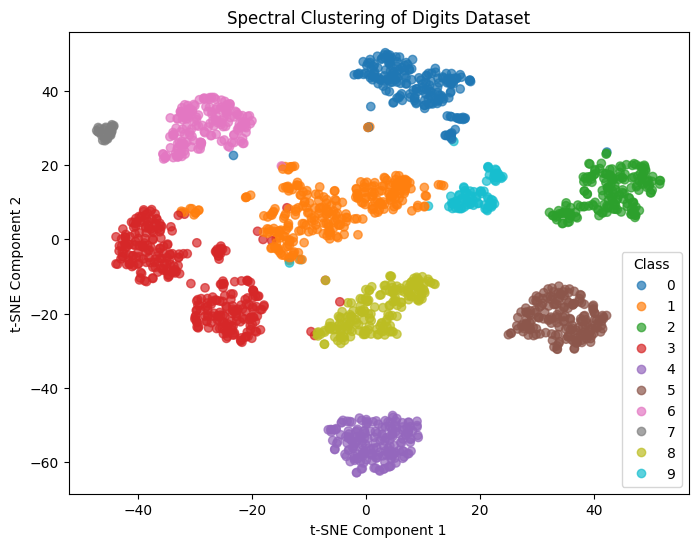

In [51]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(digits.data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=spectral_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("Spectral Clustering of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Exercício!

SUA VEZ!

Agora, vamos por os conhecimentos em prática com clusters! Baixe a base de dados `selected_images.pkl` e faça os seguintes procedimentos:
- Explore a base como quiser! Utilizando t-SNE e PCA para visualizar.
- Tente encontrar um número de classes utilizando k-Médias e SpectralClustering.
  - Você pode aplicar técnicas de redução de dimensionalidade para auxiliar!
- Tente encontrar uma configuração de hiperparâmetros que dê um bom resultado com DBSCAN!

In [ ]:
# Seu código aqui!

# DESAFIO! (Opcional)

Sem desafio hoje, Feliz Halloween!

E até a próxima, esse foi o último Laboratório :(